In [1]:
import os
import json
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


In [215]:
def load_investor_summary():
    files = list(os.walk("../scrapy_projects/etoro/etoro/"))[0][2]
    etoro_sum_paths = [f for f in files if f.startswith("investor_dashboard")]
    with open(f"../scrapy_projects/etoro/etoro/{ sorted(etoro_sum_paths)[-1]}","r") as f:
        etoro_investor_sum = json.load(f)
        
    return etoro_investor_sum


def load_investor_portfolio():
    files = list(os.walk("../scrapy_projects/etoro/etoro/"))[0][2]
    etoro_investor_paths = [f for f in files if f.startswith("investor_portfolio")]
    etoro_investors = []
    for path in etoro_investor_paths:
        with open(f"../scrapy_projects/etoro/etoro/{path}","r") as f:
            _ = json.load(f)
            etoro_investors.extend(_)


    investor_portfolio = []
    for investor in etoro_investors:
        for item in investor["items"]:
            row = {"investor_name":investor["investor_name"],
                        "date":investor["datetime"],
                        "company":item["company_ticker"],
                        "type":item["type"],
                        "invested":item["invested"].replace("<","").replace("%","")}
            investor_portfolio.append(row)
    return investor_portfolio

def load_marketwatch():
    files = list(os.walk("../scrapy_projects/marketwatch/marketwatch/"))[0][2]
    files = [f for f in files if f.startswith("marketwatch")]
    return files

def load_marketbeat():
    files = list(os.walk("../scrapy_projects/marketbeat/marketbeat/"))[0][2]
    dashboard_files = [f for f in files if f.startswith("marketbeat_dashboard")]
    dfs = []
    
    for file_path in dashboard_files:
        file_date = file_path.split("_")[-1].split(".")[0]
        with open(f"../scrapy_projects/marketbeat/marketbeat/{file_path}",'r') as f:
            this_data = json.load(f)
            df = pd.DataFrame(this_data)
            df["date"] = file_date
            df["date"] = pd.to_datetime(df["date"],format='%d-%m-%y')
            df["overall_rank"] = df["overall_rank"].apply(lambda x: x.replace("out of 5 stars",""))
            for col in df.columns:
                if col.endswith("rank"):
                    df[col] = df[col].astype(np.float64)
            dfs.append(df)
            
    return pd.concat(dfs)

def load_marketbeat_target():
    dfs = []
    with open(f"../scrapy_projects/marketbeat/marketbeat/marketbeat_price_target.json",'r') as f:
         _ = json.load(f)
    for stock in _:
        if len(stock["history"]) > 0:
            df = pd.DataFrame(stock["history"])
            df["symbol"] = stock["stock"]
            df["date"] = pd.to_datetime(df["Date"])
            df = df.drop(["Date","Unnamed: 6"],axis=1,inplace=False)
            dfs.append(df)
    return pd.concat(dfs)

def load_social_trends():
    pass



# Explore investor summary

In [188]:
investor_portfolio = load_investor_portfolio()
investor_summary = load_investor_summary()

investor_summary_df = pd.DataFrame(investor_summary)
df = pd.DataFrame(investor_portfolio)
df = df.astype({'invested': 'float32'})
df["date"] = pd.to_datetime(df["date"],format='%y-%m-%d')

In [189]:
investor_mapping = dict(zip(investor_summary_df["CustomerId"],investor_summary_df["UserName"]))
investor_summary_df = investor_summary_df.set_index("CustomerId")
investor_summary_df = investor_summary_df[['Gain', 'DailyGain', 'ThisWeekGain', 'RiskScore', 'MaxDailyRiskScore',
       'MaxMonthlyRiskScore', 'Copiers', 'CopyTradesPct', 'Trades', 'WinRatio',
       'DailyDD', 'WeeklyDD', 'ActiveWeeks','WeeksSinceRegistration']]

for col in investor_summary_df:
    investor_summary_df[col] = investor_summary_df[col].apply(lambda x: str(x).replace("$","").replace("+","").replace("M","")).astype(np.float32)

    
investor_summary = StandardScaler().fit_transform(investor_summary_df)

In [190]:
# distortions = []
# K = range(1,30)
# for k in tqdm(K):
#     kmeanModel = KMeans(n_clusters=k)
#     kmeanModel.fit(investor_summary_df)
#     distortions.append(kmeanModel.inertia_)

# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [191]:
kmeans = KMeans(25)
kmeans.fit(investor_summary)
investor_summary_df["k_means_cluster"] = kmeans.predict(investor_summary)


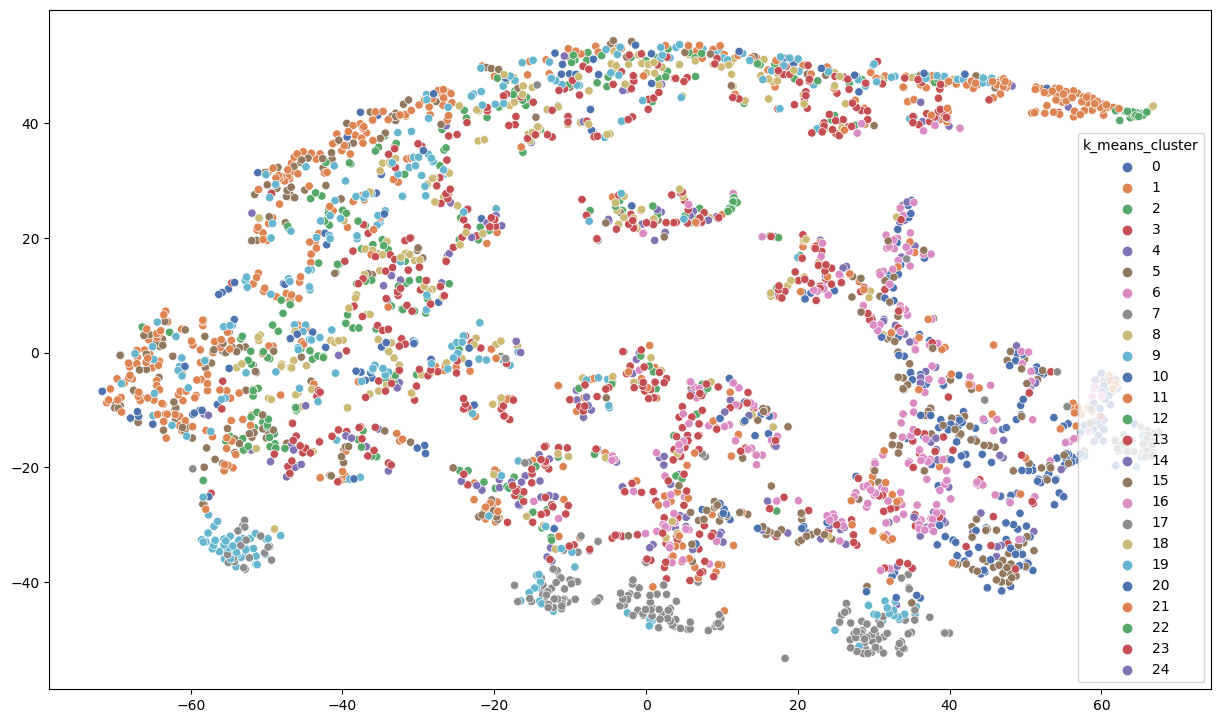

In [192]:
tsne = TSNE(n_components=2)
tsne_vals = tsne.fit_transform(investor_summary_df)

sns.scatterplot(x=tsne_vals[:,0],y=tsne_vals[:,1],hue=investor_summary_df["k_means_cluster"],palette="deep")

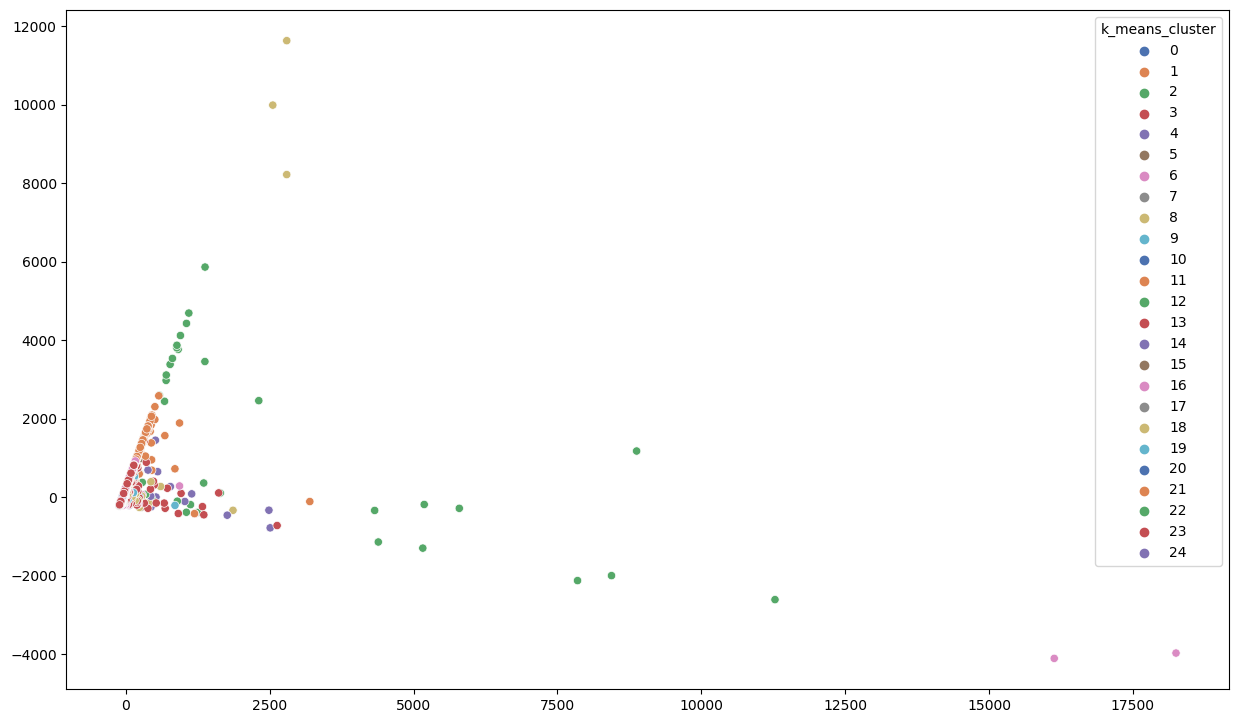

In [193]:
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(investor_summary_df)

sns.scatterplot(x=pca_vals[:,0],y=pca_vals[:,1],hue=investor_summary_df["k_means_cluster"],palette="deep")

In [194]:
summ_all = investor_summary_df.groupby("k_means_cluster").mean()
summ_all["count"] = investor_summary_df.groupby("k_means_cluster")["k_means_cluster"].count()
summ_all

,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,WeeksSinceRegistration,count
k_means_cluster,,,,,,,,,,,,,,,
0,22.431961,0.033734,-1.105886,4.424051,5.962025,4.841772,1.215190,8.758650,100.253166,66.156303,-3.517215,-5.120127,28.860760,431.063293,158
1,29.201071,-0.986104,-1.604643,5.279221,6.230519,5.256494,6.337662,2.919460,178.493500,62.593681,-3.723831,-5.422662,16.850649,38.168831,308
2,40.495823,-0.628481,-1.876287,4.172996,6.105485,5.071730,52.029537,3.433150,201.316452,72.662514,-4.078228,-6.059240,42.324894,75.417725,237
3,80.315483,-0.642343,-2.238326,4.937239,7.037657,5.920502,55.594143,2.923852,265.351471,68.805412,-8.131632,-12.139749,51.355648,111.820084,239
4,5176.029785,0.100000,-1.020000,3.000000,5.000000,3.000000,2.000000,31.578947,19.000000,47.368420,-9.390000,-9.850000,19.000000,75.000000,1
5,18.069136,-0.332054,-1.087459,3.832433,5.021622,3.767568,11.718919,4.861218,136.216217,66.354523,-2.433405,-3.497243,20.751350,57.145947,185
6,57.405003,-0.225000,-0.665000,3.500000,6.000000,5.000000,17719.500000,0.000000,403.000000,76.116280,-4.310000,-5.605000,57.000000,221.000000,2
7,25.916876,-0.216771,-1.694896,3.520833,4.625000,3.750000,1.166667,83.062416,16.666666,28.147219,-3.287917,-5.201875,50.989582,332.968750,96
8,78.833336,-2.343333,-3.043334,4.333333,6.000000,4.333333,328.333344,0.401313,10548.000000,70.371620,-4.993333,-8.330000,57.000000,77.666664,3


In [195]:
gain_quantile = summ_all['Gain'].quantile(0.5)
risk_quantile = summ_all['RiskScore'].quantile(0.7)
win_quantile = summ_all['WinRatio'].quantile(0.5)
summ = summ_all[(summ_all['WinRatio']>win_quantile)&(summ_all['Gain']>gain_quantile)&(summ_all["RiskScore"]<risk_quantile)]
summ

,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,WeeksSinceRegistration,count
k_means_cluster,,,,,,,,,,,,,,,
3,80.315483,-0.642343,-2.238326,4.937239,7.037657,5.920502,55.594143,2.923852,265.351471,68.805412,-8.131632,-12.139749,51.355648,111.820084,239
6,57.405003,-0.225000,-0.665000,3.500000,6.000000,5.000000,17719.500000,0.000000,403.000000,76.116280,-4.310000,-5.605000,57.000000,221.000000,2
8,78.833336,-2.343333,-3.043334,4.333333,6.000000,4.333333,328.333344,0.401313,10548.000000,70.371620,-4.993333,-8.330000,57.000000,77.666664,3
12,70.608887,-0.510000,-2.266667,4.222222,6.222222,5.000000,6908.000000,0.008323,905.000000,72.068710,-6.262222,-8.343333,56.555557,184.222229,9
18,71.824860,-0.710091,-2.120909,4.663636,7.359091,5.859091,34.299999,2.287583,237.127274,72.781425,-5.671591,-7.861636,42.854546,84.463638,220
22,59.112000,-0.604667,-1.297333,3.933333,6.200000,5.000000,170.600006,0.698820,4005.333252,72.808289,-5.866000,-8.331333,52.133335,157.666672,15


In [196]:
print("Best clusters", summ.index.tolist())

Best clusters [3, 6, 8, 12, 18, 22]


In [197]:
best_investors = investor_summary_df[investor_summary_df["k_means_cluster"].isin(summ.index.tolist())]
best_investors.sort_values("Gain",ascending=False)

,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,WeeksSinceRegistration,k_means_cluster
CustomerId,,,,,,,,,,,,,,,
2272833,956.479980,-0.17,-2.29,4.0,7.0,5.0,58.0,1.147228,523.0,71.510513,-4.84,-5.73,26.0,442.0,18
5459339,466.989990,0.62,0.83,3.0,7.0,6.0,3.0,15.000000,20.0,60.000000,-8.52,-13.07,23.0,245.0,3
13771807,458.019989,2.66,-2.23,6.0,7.0,6.0,15.0,0.000000,23.0,69.565216,-8.17,-13.46,43.0,43.0,3
12700067,380.609985,-0.67,-3.87,7.0,7.0,6.0,5.0,1.181102,508.0,59.448818,-9.71,-12.96,46.0,58.0,3
13392276,360.989990,0.28,14.07,6.0,7.0,6.0,5.0,0.000000,236.0,73.728813,-7.41,-8.61,46.0,47.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11750238,9.180000,-2.19,-3.18,4.0,7.0,6.0,3.0,0.000000,361.0,50.138504,-8.18,-10.30,55.0,78.0,3
7569904,8.810000,-0.93,-2.17,4.0,8.0,6.0,1.0,6.791569,427.0,57.611240,-6.34,-9.23,56.0,167.0,18
13263713,8.650000,0.05,-2.10,4.0,8.0,5.0,1.0,4.475043,581.0,70.912224,-7.10,-10.28,49.0,49.0,18


In [198]:
for investor_id in best_investors.index.values:
    print(investor_id, investor_mapping[investor_id])

5489903 rubymza
6253394 Richardstroud
10633478 Social-Investor
9629091 oceantan007
13896981 joaoguimaraes10
11011648 Martidg97
11839140 myhungetoro
7126268 Renoi974
13473154 Klaudiano13
12471987 sgstjc
13984820 zofesu
10722876 iEarnings
13281459 Pfilipp
13979721 Domics
13783286 Rotomtom
14230219 dmdesousa
6220151 danielpravia
11874624 Karlo_s
13996421 fabiovianna89
12753335 deepbluefine07
2272833 tribuluss
14882272 lplopez007
5918973 Global-Income
13194196 Doncarobert
14605988 MercifulKnight
13722009 AleNerss
16157384 JustinC2
13373282 Klimdster
12316766 stenikolaou
13946549 Aguero1010
5858504 Snapkid
13315392 Glennjdk
13810239 mark782635
13959068 acanthophis
14245020 ehoewa
14128020 rinattainov
12769387 PesaMbegu
13500837 Arthur_Koch
14170271 hoangaanh
14175828 CHW_TW
11731008 BodieCahiles
14085618 CashKing97
14594155 johnvincentmoon
6729548 jmwaller
13686455 eliasmateofs
14108684 DeniseChiew
9955093 Cjfoo68
12023676 DocPop
12787588 Brixio79
13649580 jasperyen
14111777 cfigueroa1982
1

# Explore individual stocks

In [199]:
df.head()

,investor_name,date,company,type,invested
0,rubymza,2021-01-27,MSFT,Buying,5.48
1,rubymza,2021-01-27,MA,Buying,5.46
2,rubymza,2021-01-27,AMZN,Buying,4.16
3,rubymza,2021-01-27,NVDA,Buying,4.16
4,rubymza,2021-01-27,V,Buying,3.78


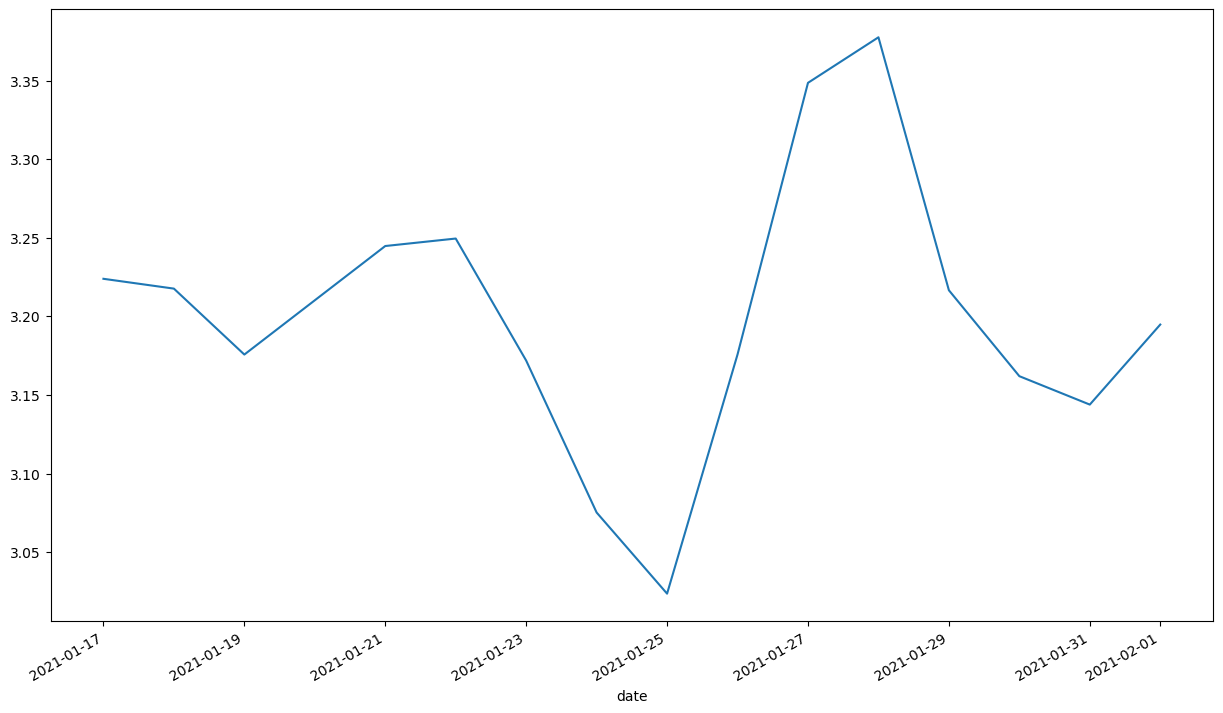

In [213]:
df[df.company=='NVDA'].groupby('date')['invested'].mean().plot()

In [201]:
dates = sorted(df.date.unique())
len(dates)

15

In [202]:
companies = df.company.unique()
len(companies)

2254

In [203]:
best_investor_stocks = df[df['investor_name'].isin([investor_mapping[i] for i in best_investors.index])]['company'].unique()
print("Best investor stocks count:", len(best_investor_stocks))

Best investor stocks count: 1135


In [204]:
groupby = df.groupby(['company','date'])["invested"].mean()
idx = pd.IndexSlice
threshold = 5
chg_interest = list()
for stock_name in tqdm(best_investor_stocks):
    last_interest = groupby.to_frame().loc[idx[stock_name, dates[-threshold]:], :]
    last_interest_mean = last_interest.mean()

    historical_interest = groupby.to_frame().loc[idx[stock_name, :dates[-threshold-1]], :]
    historical_interest_mean = historical_interest.mean()

    vals = groupby.to_frame().loc[stock_name].values.reshape(-1)
    change_in_interest = (last_interest_mean/historical_interest_mean)[0]
    chg_interest.append((stock_name,change_in_interest,historical_interest_mean[0],last_interest_mean[0]))

100%|██████████| 1135/1135 [00:07<00:00, 153.18it/s]


In [205]:
TOP_N_CHANGE_IN_INTEREST_AMONG_BEST_INVESTORS = 5
chg_intrst = pd.DataFrame.from_records(chg_interest,columns=['stock','change_in_interest',"history","latest"]).sort_values('change_in_interest',ascending=False)
chg_intrst.head(TOP_N_CHANGE_IN_INTEREST_AMONG_BEST_INVESTORS)

,stock,change_in_interest,history,latest
972,GASI.MI,10.491161,0.179167,1.879667
994,UU.L,5.654902,0.510000,2.884000
759,0656.HK,5.239999,0.050000,0.262000
731,AKE.PA,3.978947,0.352857,1.404000
869,NWG.L,3.817357,1.496737,5.713578


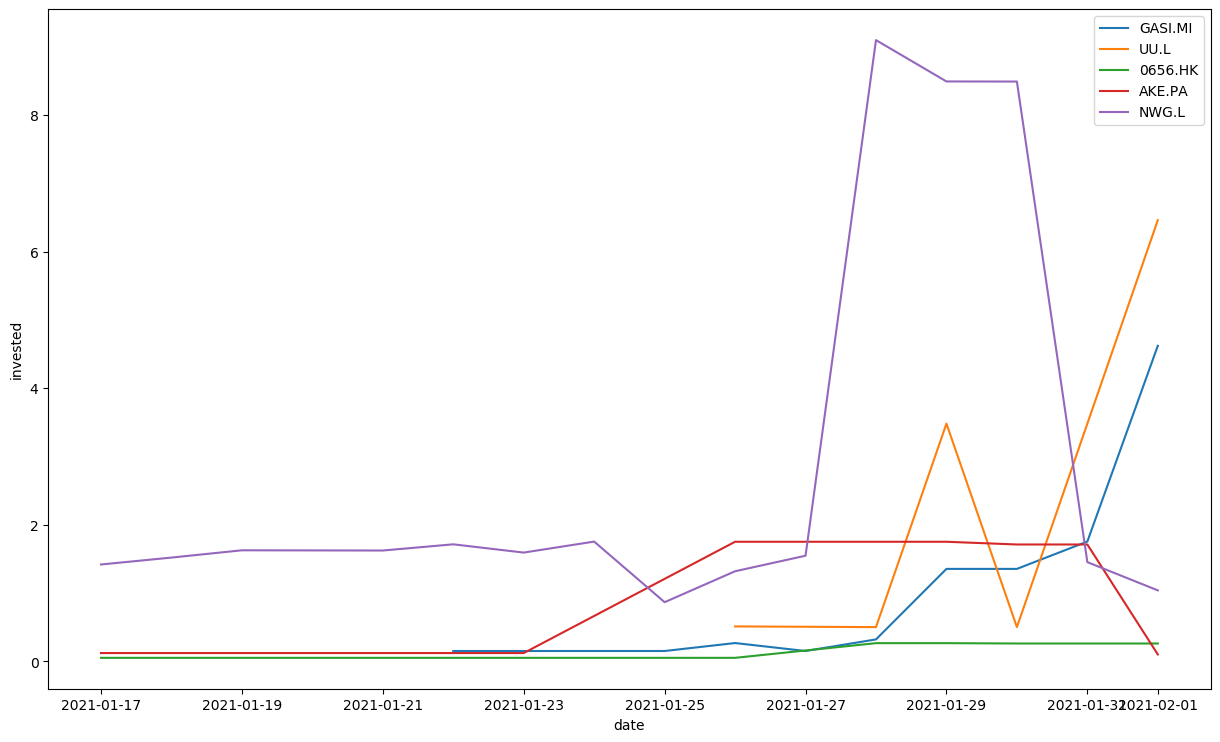

In [206]:
for int_stock in chg_intrst.head(TOP_N_CHANGE_IN_INTEREST_AMONG_BEST_INVESTORS)["stock"].values:
    vals = groupby.to_frame().loc[int_stock]
    sns.lineplot(y=vals["invested"],x=vals.index,label=int_stock)

Text(0.5, 1.0, 'Position size distribution, % of portfolio')

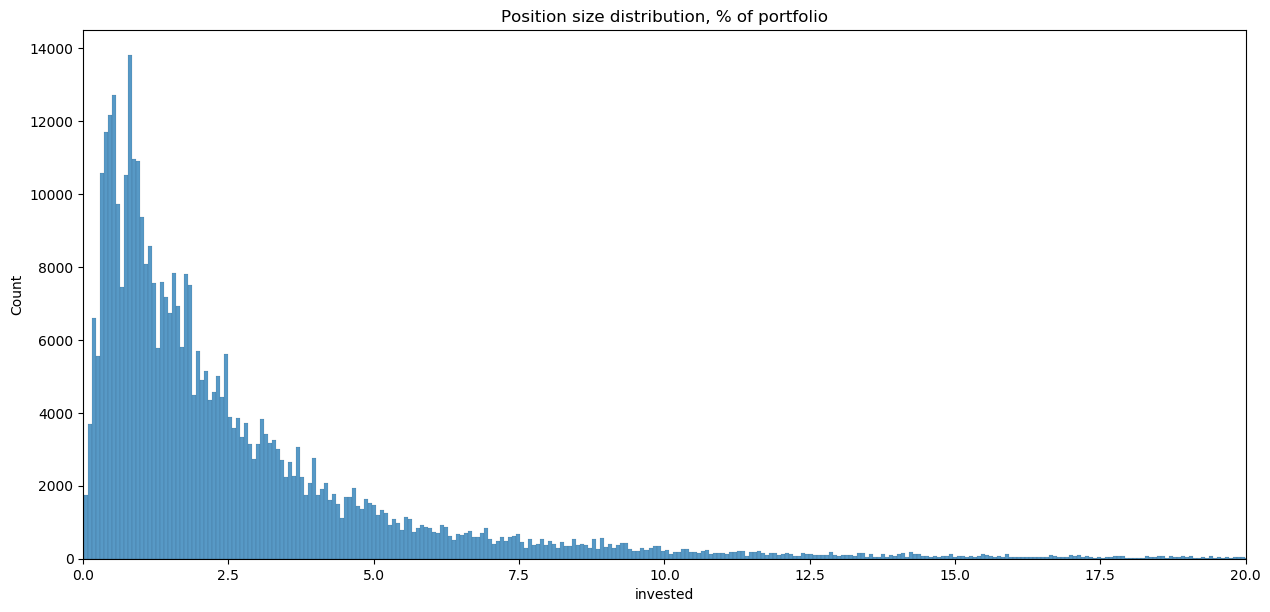

In [207]:
plt.figure(figsize=(15,7))
sns.histplot(df.invested)
plt.xlim(0,20)
plt.title("Position size distribution, % of portfolio")

overall_rank  insider_rank  community_rank  valuation_rank  \
date       symbol                                                               
2021-01-31 LNC             2.65           1.7             2.0             5.0   
           HMC             1.94           0.0             2.2             5.0   
           GFI             2.29           0.0             2.1             4.4   
           WHR             2.59           1.7             2.5             4.4   
           MBT             2.08           0.0             2.1             4.4   
...                         ...           ...             ...             ...   
           MPLX            1.16           0.0             2.7             0.0   
           COUP            0.96           0.0             2.5             0.0   
           WY              1.26           1.7             2.5             0.0   
           FIVN            1.20           1.7             3.0             0.0   
           SUZ             0.52           0.0             2.6             0.0   

                   dividend_rank  analyst_rank  
date       symbol                               
2021-01-31 LNC               2.5           2.1  
           HMC               2.5           0.0  
           GFI               1.7           3.3  
           WHR               3.3           1.1  
           MBT               1.7           2.3  
...                          ...           ...  
           MPLX              1.7           1.4  
           COUP              0.0           2.3  
           WY                0.8           1.3  
           FIVN              0.0           1.3  
           SUZ               0.0           0.0  

[1000 rows x 6 columns]

In [247]:
df_marketbeat_ranks = load_marketbeat()
mb_dates = sorted(df_marketbeat_ranks.date.unique())
df_marketbeat_ranks = df_marketbeat_ranks[df_marketbeat_ranks.date==marketbeat_latest_date].sort_values("valuation_rank",ascending=False)
df_marketbeat_ranks = df_marketbeat_ranks.set_index(["date","symbol"])
marketbeat_latest_date = mb_dates[-1]
df_marketbeat_ranks.sort_values("overall_rank",ascending=False)

overall_rank  insider_rank  community_rank  valuation_rank  \
date       symbol                                                               
2021-01-31 FANG            2.96           1.7             3.4             3.8   
           C               2.93           1.7             3.4             3.8   
           MCD             2.92           1.7             2.9             2.5   
           NOC             2.89           1.7             2.4             1.9   
           CFG             2.88           1.7             2.4             3.8   
...                         ...           ...             ...             ...   
           LBTYB           0.42           0.0             2.1             0.0   
           VIACA           0.42           0.0             0.0             1.3   
           AMOV            0.40           0.0             2.0             0.0   
           YSG             0.20           0.0             0.0             0.0   
           NTCO            0.13           0.0             0.0             0.6   

                   dividend_rank  analyst_rank  
date       symbol                               
2021-01-31 FANG              2.5           3.5  
           C                 2.5           3.3  
           MCD               4.2           3.4  
           NOC               4.2           4.3  
           CFG               3.3           3.3  
...                          ...           ...  
           LBTYB             0.0           0.0  
           VIACA             0.8           0.0  
           AMOV              0.0           0.0  
           YSG               0.0           1.0  
           NTCO              0.0           0.0  

[1000 rows x 6 columns]

In [248]:
df_marketbeat_targets = load_marketbeat_target()
df_marketbeat_targets = df_marketbeat_targets[df_marketbeat_targets.date==marketbeat_latest_date]
df_marketbeat_targets["delta"] = df_marketbeat_targets["ConsensusPriceTarget"]/df_marketbeat_targets["SharePrice"]
df_marketbeat_targets.sort_values("delta",ascending=False).head()
df_marketbeat_targets = df_marketbeat_targets.set_index(["date","symbol"])
df_marketbeat_targets.sort_values("delta",ascending=False)

ConsensusPriceTarget  MinPriceTarget  MaxPriceTarget  \
date       symbol                                                         
2021-01-31 SRNE               28.750000            26.0            35.0   
           APLS              117.642857            35.0           875.0   
           RETA              251.250000           220.0           234.0   
           KPTI               32.444444            25.0            32.0   
           BTAI              102.428571           110.0           185.0   
...                                 ...             ...             ...   
           EXPI               34.500000            53.0            53.0   
           RIOT                7.500000             7.5             7.5   
           EH                 14.000000            14.0            14.0   
           FUTU               17.900000            17.9            17.9   
           BLNK                5.000000             5.0             5.0   

                   SharePrice Currency     delta  
date       symbol                                 
2021-01-31 SRNE     10.552500        $  2.724473  
           APLS     47.764688        $  2.462967  
           RETA    111.046875        $  2.262558  
           KPTI     15.186250        $  2.136436  
           BTAI     48.985000        $  2.091019  
...                       ...      ...       ...  
           EXPI     96.670000        $  0.356884  
           RIOT     21.921875        $  0.342124  
           EH       66.733125        $  0.209791  
           FUTU     90.416875        $  0.197972  
           BLNK     48.370625        $  0.103369  

[935 rows x 6 columns]

In [250]:
df_marketbeat_ranks.join(df_marketbeat_targets,how="inner").sort_values("delta",ascending=False)

overall_rank  insider_rank  community_rank  valuation_rank  \
date       symbol                                                               
2021-01-31 OPEN            1.34           0.8             2.0             0.6   
           AZN             2.16           0.0             2.1             1.9   
           ZION            2.87           1.7             2.1             3.1   
           GILD            2.75           1.7             3.3             1.3   
           BMRN            1.86           1.7             3.1             1.3   
...                         ...           ...             ...             ...   
           TWST            1.23           1.7             2.5             0.6   
           TSLA            1.43           0.8             2.5             1.9   
           APPN            1.20           1.7             2.4             0.0   
           BILI            1.06           0.8             2.5             0.6   
           FUTU            1.06           0.0             3.8             0.0   

                   dividend_rank  analyst_rank  ConsensusPriceTarget  \
date       symbol                                                      
2021-01-31 OPEN              0.0           3.3             51.500000   
           AZN               2.5           4.3             90.000000   
           ZION              3.3           4.1             77.117647   
           GILD              3.3           4.2             94.379310   
           BMRN              0.0           3.3            116.500000   
...                          ...           ...                   ...   
           TWST              0.0           1.4             89.000000   
           TSLA              0.0           1.9            312.722581   
           APPN              0.0           2.0             71.777778   
           BILI              0.0           1.4             45.772727   
           FUTU              0.0           1.5             17.900000   

                   MinPriceTarget  MaxPriceTarget  SharePrice Currency  \
date       symbol                                                        
2021-01-31 OPEN              31.0            72.0   27.306875        $   
           AZN              175.0           175.0   52.266250        $   
           ZION              41.0           625.0   47.278750        $   
           GILD              62.0           625.0   65.775000        $   
           BMRN             108.0           110.0   85.207500        $   
...                           ...             ...         ...      ...   
           TWST             100.0           125.0  182.061875        $   
           TSLA             135.0           788.0  839.693125        $   
           APPN              76.0           100.0  195.809375        $   
           BILI              60.0            60.0  124.925625        $   
           FUTU              17.9            17.9   90.416875        $   

                      delta  
date       symbol            
2021-01-31 OPEN    1.885972  
           AZN     1.721953  
           ZION    1.631127  
           GILD    1.434881  
           BMRN    1.367251  
...                     ...  
           TWST    0.488845  
           TSLA    0.372425  
           APPN    0.366570  
           BILI    0.366400  
           FUTU    0.197972  

[320 rows x 12 columns]